# Cats: One-Class Anomaly Detection Using Support Vector Machines
Is your cat super chunky with a big heart? See for yourself by comparing your pet's body weight and heart weight to 144 other domestic cats.

This data comes from the "cats" dataset that is available inside of R's MASS library. Data were downloaded from R and imported into Python by CSV for anaylsis. 

The cats dataset contains 3 columns: 
 - Sex: Denoted "M" for male and "F" for female.
 - Bwt: The cat's body weight in kilograms, rounded to 1 decimal place.
 - Hwt: The cat's heart weight in grams in kilograms, rounded to 1 decimal place.


In [239]:
# Import packages
import os
os.getcwd()
base = 'C:\\Users\\kxr6264'
os.chdir(base)

import pandas as pd
from sklearn.svm import OneClassSVM
import seaborn as sns
import numpy as np


# Import data 
df = pd.read_csv(base + '\\cats.csv') # imports data as a data frame
df.head(10) # preview first 10 rows

,Sex,Bwt,Hwt
0,F,2.0,7.0
1,F,2.0,7.4
2,F,2.0,9.5
3,F,2.1,7.2
4,F,2.1,7.3
5,F,2.1,7.6
6,F,2.1,8.1
7,F,2.1,8.2
8,F,2.1,8.3
9,F,2.1,8.5


# Data Cleansing and Exploratory Data Analysis


In [240]:
# Print data types
# print(df.dtypes)

# Convert kg to g so weight measurements are in the same units. 1 kg = 1,000 g
df['Bwt_g'] = df['Bwt'] * 1000

# Rename column names and drop old columns to avoid redundancy
df['BodyWeight_g'] = df['Bwt_g'] # add
df['HeartWeight_g'] = df['Hwt'] #add

df = df.drop(columns=['Bwt']) # drop
df = df.drop(columns=['Bwt_g']) # drop
df = df.drop(columns=['Hwt']) #drop

In [241]:
# Drop trailing decimal place. Since we have converted units it is no longer relevant.
#df  = df.round.BodyWeight_g()
df['BodyWeight_g'] = df['BodyWeight_g'].apply(lambda x: round(x))

df.head()

,Sex,BodyWeight_g,HeartWeight_g
0,F,2000,7.0
1,F,2000,7.4
2,F,2000,9.5
3,F,2100,7.2
4,F,2100,7.3


# Data Modeling - RBF Kernel
Since we are analyzing if a value is typical among others within the same class, we will want to use a one-class Support Vector Machine.

I want to use the RBF kernel here because I assume that most data points are clustered together, with the anomalies located outside of a curved boundary.

The nu paramater tells the program what percentage of data points you want to designate as anomalies. Here, I am wanting to classify 10% of data as anomalies, so nu = 0.1. Gamma tells us how much we want each observation to be influenced by the ones it is closest to. SVM documentation states that "The larger gamma is, the closer other examples must be to be affected." 

Helpful article for explanations: https://towardsdatascience.com/support-vector-machine-svm-for-anomaly-detection-73a8d676c331


In [242]:
# drop sex column from the df so the model can analyze body weight and heart weight
df = df.drop(columns=['Sex']) # drop

# one-class SVM
model = OneClassSVM(kernel = 'rbf', gamma = 0.001, nu = 0.1).fit(df)

SVM values lie on a scale of -1 to 1. For one-class SVMs, data that are potential outliers will be caluclated as a -1.

In [243]:
# Let SVM calculate values for each cat
y_pred_rbf = model.predict(df)
y_pred_rbf


array([ 1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,
       -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1, -1, -1, -1], dtype=int64)

In [244]:
# Check to see if the 10% rule was followed 
predicted_values_df = pd.DataFrame(y_pred_rbf, columns=['Predicted Values']) 
predicted_values_df.describe()
predicted_values_df['Predicted Values'].value_counts()

 1    127
-1     17
Name: Predicted Values, dtype: int64

Notice above that the 10% rule was not exactly followed, although it is close. This is influenced by the value I chose for my gamma. You can play around with the gamma values, but keep in mind that using a gamma that is too small may overfit your model.

# Visualize results
Plotting the model's results can help to determine its validity by visualizing the predicted anomalies.  

In [245]:
# Join cats dataset with the associated SVM predicted values into one df
joined_df = df.join(predicted_values_df, lsuffix="_left") # lsuffix joins these two dataframes by their row index
joined_df.head()

# Create column to clearly label outliers vs non-outliers
joined_df['Anomalies'] = np.where(joined_df['Predicted Values'] == -1, "Anomaly", "Non-Anomaly")

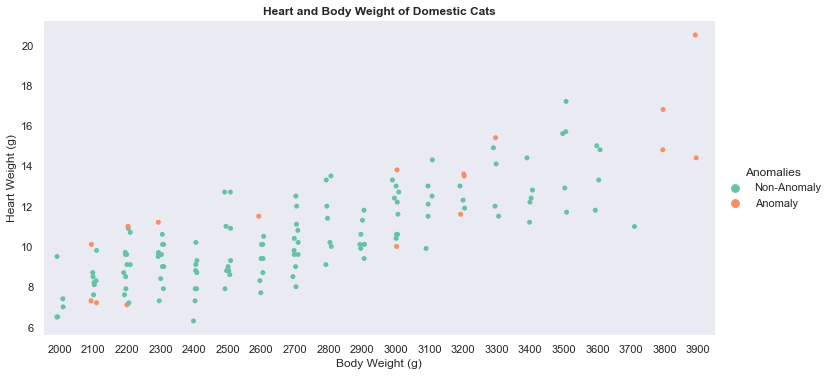

In [248]:
# Plot results. Ironically, we will be using Seaborn's cat plot!
# height and aspect parameters change the dimensions of the plot: https://www.statology.org/seaborn-figure-size/
sns.set(style='dark') # set background color for plot
sns.catplot(x="BodyWeight_g", y="HeartWeight_g", height=5, aspect=2,hue="Anomalies", palette="Set2",data=joined_df)


# Change axis labels
plt.xlabel("Body Weight (g)")
plt.ylabel("Heart Weight (g)")
plt.title("Heart and Body Weight of Domestic Cats", weight='bold') # bold title

# Save image
plt.savefig("cats.png")